# Renewable Energy Heat

- Juan Manuel Boullosa Novo
- Alberto Jimenez Haro
- Emre ...

In [33]:
from CoolProp.CoolProp import PropsSI
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import _roomClass as rc # Custom class required ./_roomClass.py

Function definition for heating demand

In [34]:
def calculate_heating_demand(location, coldRoom):
    heating_demand = location.calculate_yearly_heating_demand(coldRoom)
    rc.Plotter.plot_heating_demand(location.months, heating_demand, location.average_temperatures)
    print("Heating demand for each month:")
    for month, demand in zip(location.months, heating_demand):
        print(f"{month}: {demand:.2f} kW")
    print(f"Average heating demand: {np.mean(heating_demand):.2f} kW")
    return heating_demand

We set the parameters for the location and the room and create the instances.

In [35]:
average_temperature_hamburg = [1.7, 2, 4.5, 9.1, 13.3, 16.3, 18.5, 18.1, 14.9, 10.5, 6, 3] # in °C [Source: https://en.climate-data.org/europe/germany/hamburg/hamburg-69/]
desired_freezer_temperature = -18 # in °C
coldroom_dimensions = [4, 3, 2] # in meters
floor_material = "Concrete"
wall_material = "Polyurethane foam"
ceiling_material = "Polyurethane foam"

coldRoom = rc.Room(coldroom_dimensions, floor_material, wall_material, ceiling_material, 50, 15, 20, desired_freezer_temperature)    
hamburg = rc.ClimateData(average_temperature_hamburg)

We calculate the yearly heating demand

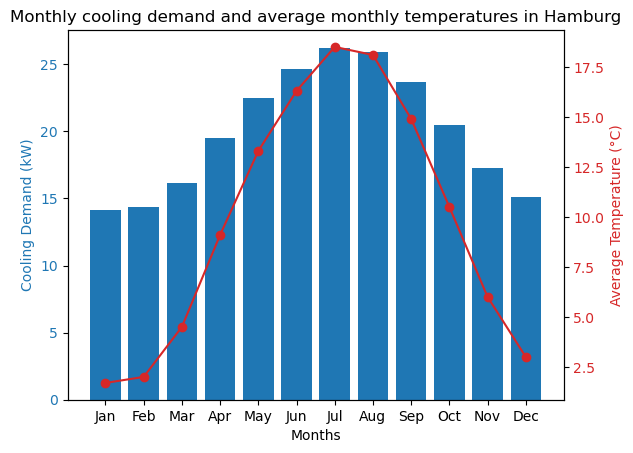

Heating demand for each month:
Jan: 14.16 kW
Feb: 14.37 kW
Mar: 16.17 kW
Apr: 19.48 kW
May: 22.49 kW
Jun: 24.65 kW
Jul: 26.23 kW
Aug: 25.94 kW
Sep: 23.64 kW
Oct: 20.48 kW
Nov: 17.25 kW
Dec: 15.09 kW
Average heating demand: 20.00 kW


In [36]:
yearly_heating_demand = calculate_heating_demand(hamburg, coldRoom)

Let's create a function that calculates the evaporators heat, the power and the cop:

In [38]:
def cop_and_heat_calculations(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation.

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s. Are these enthalpies correct? or should we get h_4, h_3
    power = m * abs(h_3 - h_2) # compressor power
    cop = abs(heat_evap) / power
    heat_cond = abs(heat_evap) - power

    cop_carnot = temp_2 / (temp_2 - temp_4)
    efficiency_hp = cop / cop_carnot
    
    return m, power, cop, heat_cond, cop_carnot, efficiency_hp

def seasonal_cop_and_heat_calculations(refr_fluid, evap_temp, cond_temp_list, efficiency_compressor, heat_evap):


Let's select some of the necessary parameters for our study:

In [32]:
# outside_temp = 15 + 273.15 # Average temperature in Hamburg in Kelvin
# desired_temp = -18 + 273.15 # C Desired temperatures

cond_temp = outside_temp + 20
evap_temp = desired_temp - 10

evap_temp_list = np.arange(evap_temp - 10 , evap_temp + 10 , 2)
cond_temp_list = np.arange(cond_temp - 10 , cond_temp + 10 , 2)

refr_fluid = "R290"
efficiency_compressor = 0.8 # Efficiency assumed to be 80%
heat_evap = 2e5 # Nominal heat power (W)

Let's calculate and plot the COP for different evaporation and condensation temperatures:

Text(0.5, 1.0, 'COP vs Condensator T')

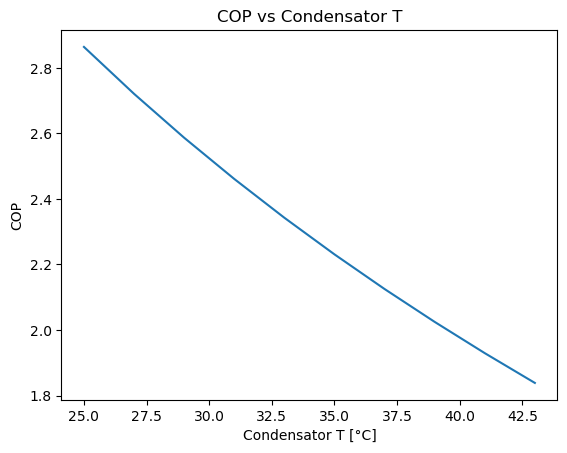

In [8]:
# Calculating COP vs Condensator Temps:
mass_sec, pow, cop, heat_condensator, _, _ = cop_and_heat_calculations(
    refr_fluid, evap_temp, cond_temp_list, efficiency_compressor, heat_evap
)

# Plotting results condensator changing temps:
plt.plot(cond_temp_list - 273.15, cop)
plt.xlabel('Condensator T [°C]')
plt.ylabel('COP')
plt.title('COP vs Condensator T')

Text(0.5, 1.0, 'COP vs Evaporator T')

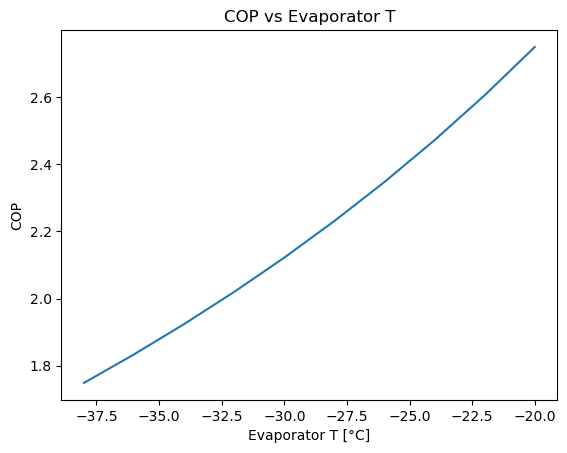

In [9]:
# Calculating COP vs Evaporator Temps:
mass_sec_ev, pow_ev, cop_ev, heat_condensator_ev, _, _ = cop_and_heat_calculations(
    refr_fluid, evap_temp_list, cond_temp, efficiency_compressor, heat_evap
)

# Plotting results evaporator changing temps:
plt.plot(evap_temp_list - 273.15, cop_ev)
plt.xlabel('Evaporator T [°C]')
plt.ylabel('COP')
plt.title('COP vs Evaporator T')

Now, let's plot both the condensated T° and the evaporated T° in the same 3D graph to compare results:

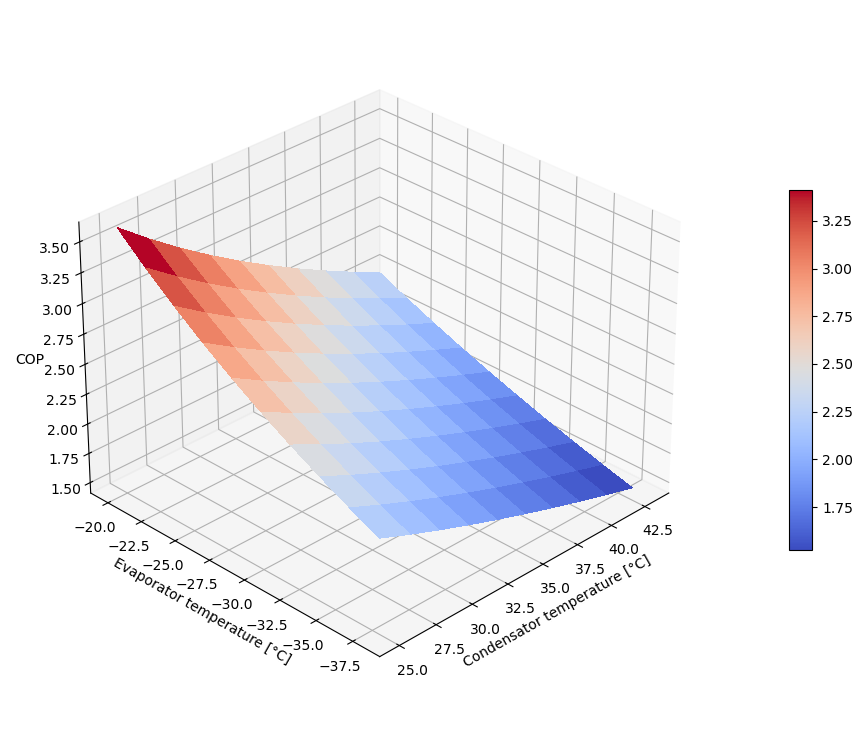

In [10]:
param_cop = pd.DataFrame(
    index=evap_temp_list, 
    columns=cond_temp_list
)

for ev_temp in evap_temp_list:
    _, _, cop, _, _, _ = cop_and_heat_calculations(
        refr_fluid, 
        ev_temp, 
        cond_temp_list, 
        efficiency_compressor, 
        heat_evap
    )
    param_cop.loc[ev_temp] = cop

param_cop

# Plot 3D Figure:
fig, ax = plt.subplots(1, figsize=(12, 7.5), subplot_kw={"projection": "3d"})

X, Y = np.meshgrid(cond_temp_list - 273.15, evap_temp_list - 273.15)

surf = ax.plot_surface(X, Y, param_cop.values, cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax.set_xlabel("Condensator temperature [°C]")
ax.set_ylabel("Evaporator temperature [°C]")
ax.set_zlabel("COP")
ax.view_init(elev=30, azim=225)
ax.set_box_aspect(aspect=None, zoom=0.9)
fig.colorbar(surf, shrink=0.5, aspect=15)
plt.tight_layout()

Let's try plot the P-H Diagram:

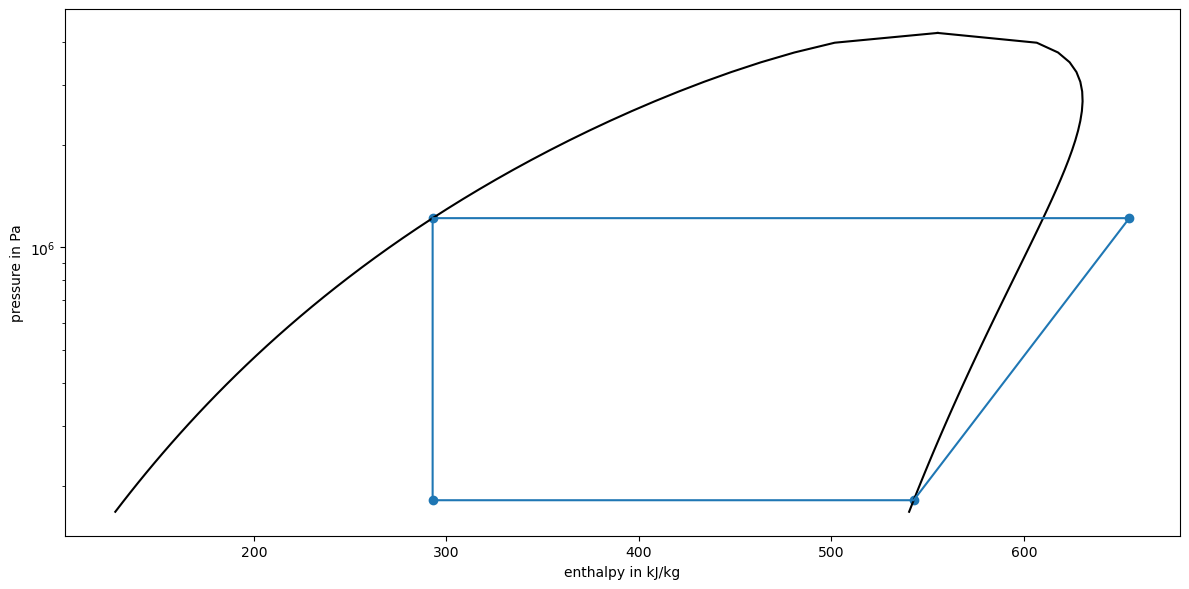

In [11]:

def press_and_enthalpy_calc(fluid, temp_2, temp_4, efficiency_compressor, heat_evap):
    s_2 = PropsSI("S", "T", temp_2, "Q", 1, fluid)
    h_2 = PropsSI("H", "T", temp_2, "Q", 1, fluid)
    press_2 = PropsSI("P", "T", temp_2, "Q", 1, fluid)
    press_4 = PropsSI("P", "T", temp_4, "Q", 0, fluid)
    press_3 = press_4 # pressure remains same after compressor / before expansion

    h_3s = PropsSI("H", "S", s_2, "P", press_3, fluid)
    h_3 = h_2 + (h_3s - h_2) / efficiency_compressor # enthalpy considering compressor efficiency

    h_4 = PropsSI("H", "T", temp_4, "Q", 0, fluid)
    h_1 = h_4 # enthalpy remains constant in expansion. refer to ph graph
    press_1 = press_2 # pressure remains constant in evaporation.

    # no calculamos s_1, s_3, s_4, t_1, t_3

    m = heat_evap / abs(h_2 - h_1) # mass flow rate kg/s. Are these enthalpies correct? or should we get h_4, h_3
    power = m * abs(h_3 - h_2) # compressor power
    cop = abs(heat_evap) / power
    heat_cond = abs(heat_evap) - power
    
    return h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4

h_1, h_2, h_3, h_4, press_1, press_2, press_3, press_4 = press_and_enthalpy_calc(
    refr_fluid, evap_temp, cond_temp, efficiency_compressor, heat_evap
)

p_range = np.geomspace(PropsSI("P", "T", 273.15 -30, "Q", 0, refr_fluid), PropsSI("PCRIT", refr_fluid))
boiling_line = PropsSI("H", "P", p_range, "Q", 0, refr_fluid) / 1e3
dew_line = PropsSI("H", "P", p_range, "Q", 1, refr_fluid) / 1e3

fig, ax = plt.subplots(1, figsize=(12, 6))

ax.set_yscale("log")
ax.plot(boiling_line, p_range, color="#000")
ax.plot(dew_line, p_range, color="#000")

ax.scatter([h / 1e3 for h in [h_1, h_2, h_3, h_4]], [press_1, press_2, press_3, press_4])
ax.plot([h / 1e3 for h in [h_1, h_2, h_3, h_4, h_1]], [press_1, press_2, press_3, press_4, press_1])

ax.set_ylabel("pressure in Pa")
ax.set_xlabel("enthalpy in kJ/kg")

_x_lims = ax.get_xlim()
_y_lims = ax.get_ylim()


plt.tight_layout()